# 3 layer LSTM1 Regularized, dropout. 30 day input, 7 day forecast

In [5]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from keras.models import Sequential, load_model
from keras import regularizers
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
save_dir = 'models/lstm1'
df = pd.read_csv('data_25_standardized.csv', index_col='Date')
data = df.values

In [7]:
num_input = 30
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, y = utils.prepare_data(data, num_input, num_preds=num_out)

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)

train_X shape (638, 30, 25)
train_y shape (638, 7)
dev_X shape (80, 30, 25)
dev_y shape (80, 7)
test_X shape (80, 30, 25)
test_y shape (80, 7)


In [18]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(
    CuDNNLSTM(
        128,
        input_shape=input_shape,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.005)
    )
)
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.005)))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, kernel_regularizer=regularizers.l2(0.005),))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(Dense(32, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(num_out, activation="linear"))


opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_6 (CuDNNLSTM)     (None, 30, 128)           79360     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 128)           512       
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 30, 128)           132096    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 128)           512       
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 128)               132096    
__________

In [19]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 638 samples, validate on 80 samples
Epoch 1/200
638/638 [==============================] - 2s 4ms/step - loss: 3.7633 - val_loss: 2.4275
Epoch 2/200
638/638 [==============================] - 1s 1ms/step - loss: 3.0860 - val_loss: 2.2544
Epoch 3/200
638/638 [==============================] - 1s 1ms/step - loss: 2.7689 - val_loss: 2.1060
Epoch 4/200
638/638 [==============================] - 1s 1ms/step - loss: 2.4923 - val_loss: 1.9525
Epoch 5/200
638/638 [==============================] - 1s 1ms/step - loss: 2.2609 - val_loss: 1.7983
Epoch 6/200
638/638 [==============================] - 1s 1ms/step - loss: 2.0948 - val_loss: 1.6467
Epoch 7/200
638/638 [==============================] - 1s 1ms/step - loss: 1.9052 - val_loss: 1.5408
Epoch 8/200
638/638 [==============================] - 1s 1ms/step - loss: 1.7309 - val_loss: 1.3952
Epoch 9/200
638/638 [==============================] - 1s 1ms/step - loss: 1.5972 - val_

Epoch 160/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1320 - val_loss: 0.2098
Epoch 161/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1259 - val_loss: 0.2116
Epoch 162/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1107 - val_loss: 0.2355
Epoch 163/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1114 - val_loss: 0.1980
Epoch 164/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1059 - val_loss: 0.2170
Epoch 165/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1137 - val_loss: 0.1996
Epoch 166/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1034 - val_loss: 0.2712
Epoch 167/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1067 - val_loss: 0.2549
Epoch 168/200
638/638 [==============================] - 1s 1ms/step - loss: 0.1102 - val_loss: 0.3339
Epoch 169/200
638/638 [==============================] - 1s 1ms/step - lo

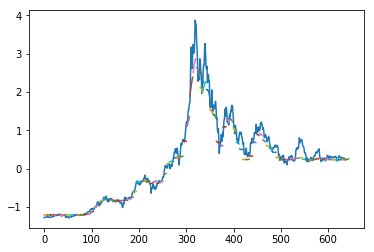

In [20]:
predicted_train = model.predict(train_X)
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

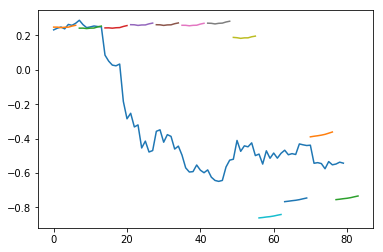

In [21]:
predicted_dev = model.predict(dev_X)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

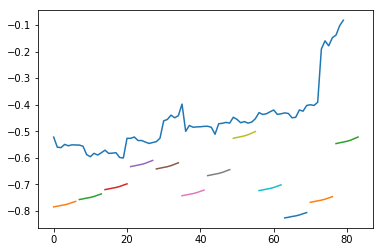

In [22]:
predicted_test = model.predict(test_X)
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [23]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.04521751345155175
MSE Dev: 0.2721215852722553
MSE Test: 0.07014537768839679


In [24]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5510204081632653
Acc Dev: 0.4936708860759494
Acc Test: 0.5443037974683544


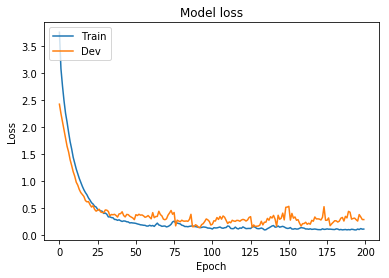

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()